In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from random import random

In [19]:
import randomized_ir

from utils import generate_poissonian_ns
import plots

In [20]:
matplotlib.rcParams.update({'font.size': 12})

In [28]:
from importlib import reload

def reload_modules():
    reload(randomized_ir)
    reload(plots)

## IR

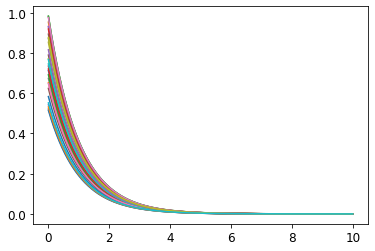

In [22]:
gamma = 1

pts_per_bin = 100
L_true = 10

ir_x = np.linspace(0, L_true, int(L_true * pts_per_bin))

# exp-decay
ir_y = np.exp(- gamma * ir_x)

# step
# step_witdh = 2
# ir_y = (ir_x < step_witdh).astype('float')

rir = randomized_ir.RandomizedIr(ir_x, ir_y, factor=lambda: 0.5 + random()*0.5)

rir.plot_realizations(count=30)

# Convoluted signal

Pic: `\ref{pic:problem-setup}`


In [23]:
N = 50
n_vec_mean = 15

n_vec = generate_poissonian_ns(n_vec_mean, N)

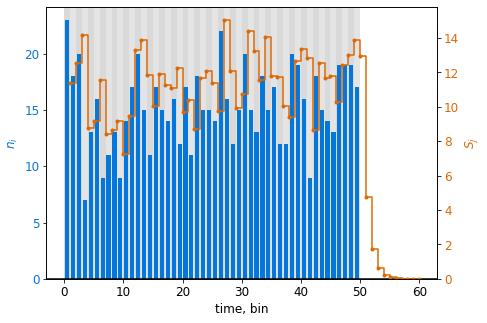

In [24]:
S_vec = rir.convolve_with_n_vec(n_vec)

# for non trivial inbin time distribution:
# S_vec = rir.convolve_with_n_vec(n_vec, inbin_invcdf=lambda x: x**(1/10), debug_inbin_times=True)

plots.plot_convolution(n_vec, S_vec)

# Mean-based estimation

Chapter: `Грубая оценка методом наименьших квадратов`

In [36]:
stats = randomized_ir.RandomizedIrStats(rir, samplesize=100000)

n_vec_estimation = stats.estimate_n_vec(S_vec)

In [34]:
reload_modules()

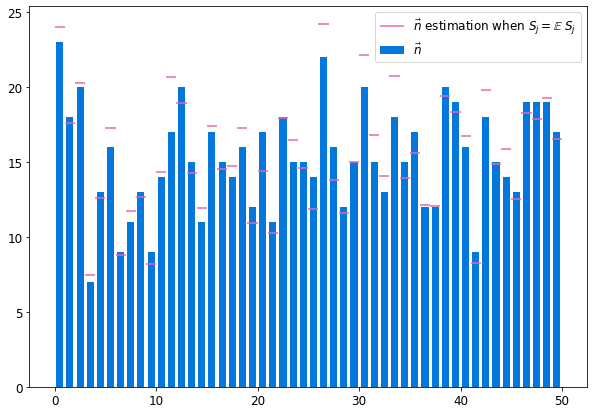

In [37]:
plots.plot_mean_n_estimation(n_vec, n_vec_estimation)

# MCMC-based estimation
Starring MGF

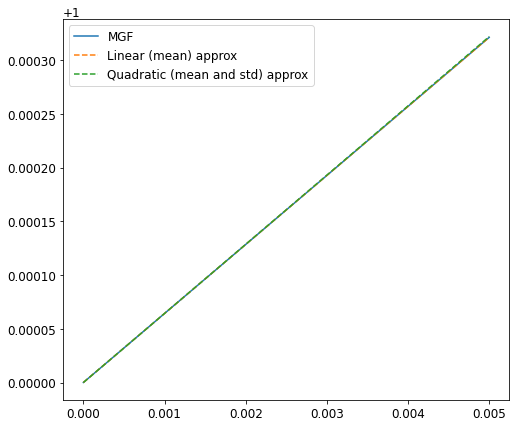

In [27]:
stats.plot_mgf(tmax=0.005, n=1, lag=3)